# Determining a perspective tariff for a telecom company


## Data description
### Table users (user information):
- user_id - unique user ID
- first_name - user name
- last_name - user's last name
- age - user age (years)
- reg_date - tariff activation date (day, month, year)
- churn_date - date when user discontinued the tariff (if value is missing, then tariff was active at the moment of data uploading)
- city - user's city of residence
- tariff - name of tariff plan
### Table of calls (information about calls):
- id - unique number of the call
- call_date - date of the call
- duration - duration of the call in minutes
- user_id - identifier of the user that made the call
### Table messages (information about messages):
- id - unique number of the message
- message_date - date of the message
- user_id - identifier of the user who sent the message
- Table internet (information about internet sessions):
- id - unique session number
- mb_used - amount of the Internet traffic spent during the session (in megabytes)
- session_date - date of the Internet session
- user_id - user ID
### tariffs table (information about the tariffs):
- tariff_name - tariff name
- rub_monthly_fee - monthly subscription fee in rubles
- minutes_included - number of minutes of conversation per month included in the subscription fee
- messages_included - number of messages per month included in the subscription fee
- mb_per_month_included - amount of the Internet traffic included in the subscription fee (in megabytes)
- rub_per_minute - the cost of a minute of conversation over the tariff package (for example, if the tariff has 100 minutes of conversation per month, then 101 minutes will be charged)
- rub_per_message - cost of sending a message over the tariff package
- rub_per_gb - the cost of one additional gigabyte of Internet traffic above the tariff package (1 gigabyte = 1024 megabytes)


## Opening of data

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
calls = pd.read_csv('/project/datasets/calls.csv')

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.duplicated().sum()

0

In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


The file with data on calls made contains 202607 lines, no duplicate values were detected. We need to change 'call_date' data type to datetime.

In [6]:
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')

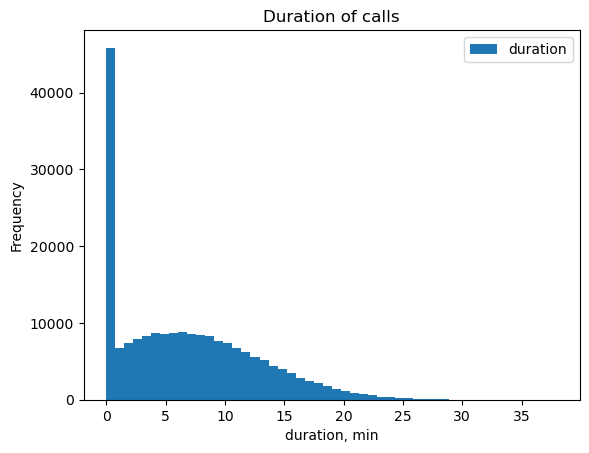

In [7]:
calls.plot(y = 'duration', kind = 'hist', bins = 50, title = 'Duration of calls')
plt.xlabel('duration, min')
plt.ylabel('Frequency')
plt.show()

The histogram shows the peak values with the duration of calls of 0 min. Spent minutes with the duration of "0" are not charged, respectively, do not affect the choice of tariff and the profit of the company. Thus, calls with a duration of 0 minutes are not necessary.

In [8]:
calls = calls.query('duration != 0').reset_index(drop=True)

In [9]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162994 entries, 0 to 162993
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         162994 non-null  object        
 1   call_date  162994 non-null  datetime64[ns]
 2   duration   162994 non-null  float64       
 3   user_id    162994 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.0+ MB


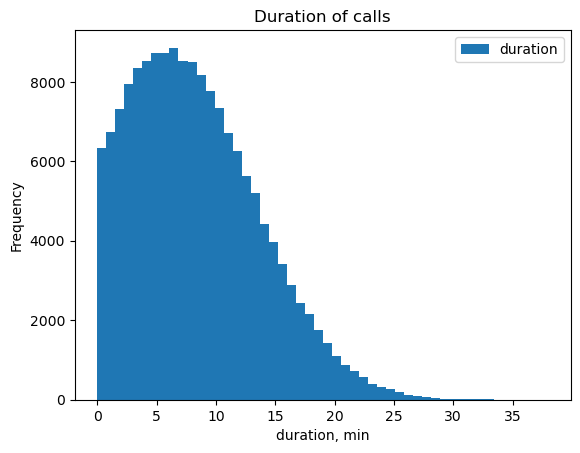

In [10]:
calls.plot(y = 'duration', kind = 'hist', bins = 50, title = 'Duration of calls')
plt.xlabel('duration, min')
plt.ylabel('Frequency')
plt.show()

Create a variable 'month' with the values of the months during which the calls were made

In [11]:
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

Let's group call data by 'user_id', month, and display the number of calls, average duration, and amount of minutes spent per month.

In [12]:
calls_stat = (calls
 .groupby(['user_id','month'])['duration'].agg(['count','mean','sum']).round(2)
)

In [13]:
calls_stat.columns = ['calls_number','calls_mean_duration','calls_total_duration']

In [14]:
calls_stat.head()

calls_number  calls_mean_duration  calls_total_duration
user_id month                                                              
1000    2018-05-01            17                 8.83                150.06
        2018-06-01            28                 5.68                158.90
        2018-07-01            41                 7.78                318.80
        2018-08-01            42                 9.28                389.87
        2018-09-01            46                 9.57                440.14

Let's open the file with data on sent SMS.

In [15]:
messages = pd.read_csv('/project/datasets/messages.csv')

In [16]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [17]:
messages.duplicated().sum()

0

In [18]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


The file contains 123036 lines, no duplicates or empty values. Let's replace the data type in the 'message_date' variable with datetime.

In [19]:
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y-%m-%d')

In [20]:
messages['month'] = messages['message_date'].values.astype('datetime64[M]')

Create a table with data on the number of messages sent per month for each user.

In [21]:
messages_stat = (messages
 .groupby(['user_id','month'])['message_date'].agg(['count'])
)

In [22]:
messages_stat.columns = ['messages_sent']

In [23]:
messages_stat.head()

messages_sent
user_id month                    
1000    2018-05-01             22
        2018-06-01             60
        2018-07-01             75
        2018-08-01             81
        2018-09-01             57

Let's take a look at the file with data on Internet traffic usage by users.

In [24]:
internet = pd.read_csv('/project/datasets/internet.csv')

In [25]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [26]:
internet.duplicated().sum()

0

In [27]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


The table contains 129798 rows, no duplicates, no missing values. Let's change the 'session_date' variable type to datetime.

In [28]:
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y-%m-%d')

Create a variable with information about the activity month.

In [29]:
internet['month'] = internet['session_date'].values.astype('datetime64[M]')

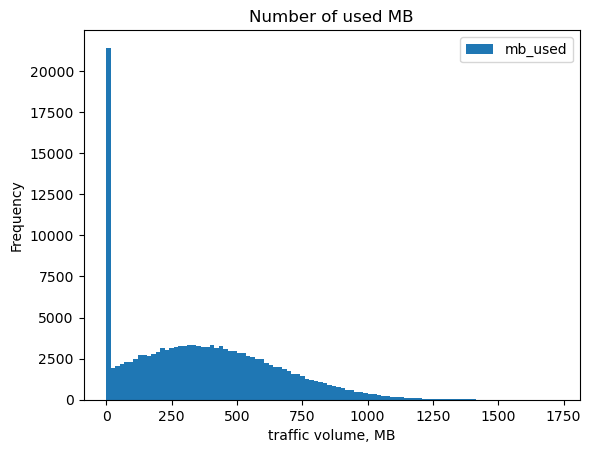

In [30]:
internet.plot(y = 'mb_used', kind = 'hist', bins = 100, title = 'Number of used MB')
plt.xlabel('traffic volume, MB')
plt.ylabel('Frequency')
plt.show()

In the data there are many values with the volume of traffic 0 Gb, this value is not charged, we will not use the data with the volume of 0 Gb.

In [31]:
len(internet[internet['mb_used'] == 0])

19598

In [32]:
internet = internet.query('mb_used != 0').reset_index(drop = True)

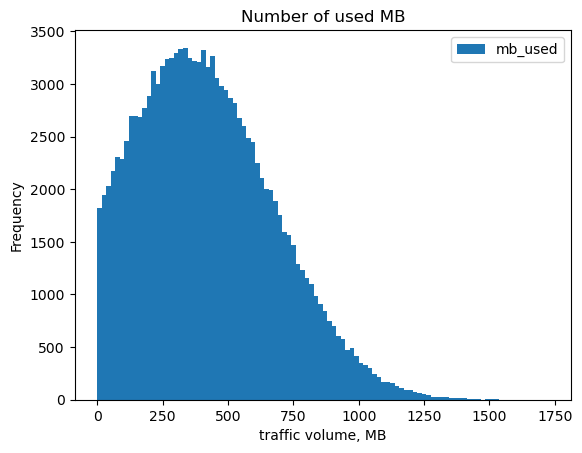

In [33]:
internet.plot(y = 'mb_used', kind = 'hist', bins = 100, title = 'Number of used MB')
plt.xlabel('traffic volume, MB')
plt.ylabel('Frequency')
plt.show()

Let's form a table with information about the volume of Internet traffic of users by month.

In [34]:
internet_stat = (internet
 .groupby(['user_id','month'])['mb_used'].agg(['count','sum'])
)

In [35]:
internet_stat.head()

count       sum
user_id month                      
1000    2018-05-01      4   2253.49
        2018-06-01     44  23233.77
        2018-07-01     28  14003.64
        2018-08-01     27  14055.93
        2018-09-01     25  14568.91

In [36]:
internet_stat.columns = ['sessions_number','mb_used']

In [37]:
internet_stat.mean()

sessions_number       40.549203
mb_used            17277.496948
dtype: float64

Let's take a look at the user data file.

In [38]:
users = pd.read_csv('/project/datasets/users.csv')

In [39]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [40]:
users.duplicated().sum()

0

In [41]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


The file contains data on 500 users, there are gaps in the variable churn_date, ie 38 users have changed rates, at the time of data unloading.

Let's create a variable with the data about the user's registration month.

In [42]:
users['reg_month'] = users['reg_date'].values.astype('datetime64[M]')

## Merging tables

In [43]:
min_month = users['reg_date'].values.astype('datetime64[M]').min()
min_month

numpy.datetime64('2018-01')

In [44]:
max_month = users['reg_date'].values.astype('datetime64[M]').max()
max_month

numpy.datetime64('2018-12')

Create a variable with a date range from the first to the last month of user registration

In [45]:
pd.date_range(min_month,max_month,freq='MS')

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [46]:
dr = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))

In [47]:
dr.columns = ['month']

Let's estimate the size of the table after the merge

In [48]:
len(users)*len(dr)

6000

In [49]:
dr['key'] = 1
users['key'] = 1

In [50]:
report = dr.merge(users,on='key')

In [51]:
report.head()

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
0,2018-01-01,1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
1,2018-01-01,1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01
2,2018-01-01,1,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06-01
3,2018-01-01,1,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,2018-08-01
4,2018-01-01,1,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018-05-01


In [52]:
len(report)

6000

In [53]:
report = report.merge(calls_stat,on=['user_id','month'], how='left').copy()

In [54]:
calls_stat['calls_total_duration'].sum()

1368790.04

In [55]:
report['calls_total_duration'].sum()

1368790.04

In [56]:
report = report.merge(messages_stat,on=['user_id','month'], how='left').copy()

In [57]:
messages_stat['messages_sent'].sum()

123036

In [58]:
report['messages_sent'].sum()

123036.0

In [59]:
report = report.merge(internet_stat,on=['user_id','month'], how='left').copy()

In [60]:
internet_stat['mb_used'].sum()

55305267.730000004

In [61]:
report['mb_used'].sum()

55305267.73

Tables with information about calls, messages and Internet traffic are combined with the table with data about users. The sums of the values have converged, nothing has been lost or added.

In [62]:
report.query('user_id == 1495')

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,calls_number,calls_mean_duration,calls_total_duration,messages_sent,sessions_number,mb_used
495,2018-01-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,NaN,NaN,NaN,NaN,NaN,NaN
995,2018-02-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1495,2018-03-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1995,2018-04-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,NaN,NaN,NaN,NaN,NaN,NaN
2495,2018-05-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,NaN,NaN,NaN,NaN,NaN,NaN
2995,2018-06-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,NaN,NaN,NaN,NaN,NaN,NaN
3495,2018-07-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,NaN,NaN,NaN,NaN,NaN,NaN
3995,2018-08-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,13.0,6.69,87.03,13.0,4.0,2614.07
4495,2018-09-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,95.0,8.07,766.62,82.0,67.0,33067.62
4995,2018-10-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,126.0,7.71,971.33,82.0,57.0,29363.00


In [63]:
report['calls_total_duration'].isna().sum()

2832

In [64]:
report['messages_sent'].isna().sum()

3283

In [65]:
report['mb_used'].isna().sum()

2799

'NaN' appeared in the table because some users registered later than the initial sampling period.

In [66]:
len(report[report['month']>=report['reg_month']])

3259

In [67]:
report = report[report['month']>=report['reg_month']]

In [68]:
report.query('user_id == 1495')

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,calls_number,calls_mean_duration,calls_total_duration,messages_sent,sessions_number,mb_used
3995,2018-08-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,13.0,6.69,87.03,13.0,4.0,2614.07
4495,2018-09-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,95.0,8.07,766.62,82.0,67.0,33067.62
4995,2018-10-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,126.0,7.71,971.33,82.0,57.0,29363.00
5495,2018-11-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,112.0,7.97,892.65,79.0,70.0,38939.11
5995,2018-12-01,1,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-01,120.0,8.09,970.94,84.0,46.0,23426.76


In [69]:
report[report['calls_total_duration'].isna()]

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,calls_number,calls_mean_duration,calls_total_duration,messages_sent,sessions_number,mb_used
373,2018-01-01,1,1373,34,NaN,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,2018-01-01,NaN,NaN,NaN,28.0,19.0,9173.74
740,2018-02-01,1,1240,30,NaN,Воронеж,Зинаида,Шарова,2018-02-27,ultra,2018-02-01,NaN,NaN,NaN,NaN,3.0,959.51
1606,2018-04-01,1,1106,67,NaN,Калуга,Исаак,Костин,2018-04-26,ultra,2018-04-01,NaN,NaN,NaN,9.0,4.0,2923.49
1873,2018-04-01,1,1373,34,NaN,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,2018-01-01,NaN,NaN,NaN,48.0,53.0,20375.78
1976,2018-04-01,1,1476,50,NaN,Москва,Валентина,Семенова,2018-04-30,ultra,2018-04-01,NaN,NaN,NaN,NaN,1.0,530.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5892,2018-12-01,1,1392,54,2018-09-27,Челябинск,Алла,Беликова,2018-02-27,ultra,2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN
5973,2018-12-01,1,1473,18,NaN,Красноярск,Николай,Лебедев,2018-08-05,ultra,2018-08-01,NaN,NaN,NaN,20.0,30.0,18418.26
5980,2018-12-01,1,1480,29,2018-09-26,Новокузнецк,Гелена,Емельянова,2018-02-14,smart,2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN
5989,2018-12-01,1,1489,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,2018-08-01,NaN,NaN,NaN,35.0,43.0,17322.51


In [70]:
report.query('user_id == 1373')

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,calls_number,calls_mean_duration,calls_total_duration,messages_sent,sessions_number,mb_used
373,2018-01-01,1,1373,34,NaN,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,2018-01-01,NaN,NaN,NaN,28.0,19.0,9173.74
873,2018-02-01,1,1373,34,NaN,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,2018-01-01,1.0,1.78,1.78,38.0,44.0,20171.16
1373,2018-03-01,1,1373,34,NaN,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,2018-01-01,2.0,10.48,20.95,55.0,63.0,22620.56
1873,2018-04-01,1,1373,34,NaN,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,2018-01-01,NaN,NaN,NaN,48.0,53.0,20375.78
2373,2018-05-01,1,1373,34,NaN,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,2018-01-01,2.0,6.22,12.43,48.0,74.0,29724.08
2873,2018-06-01,1,1373,34,NaN,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,2018-01-01,NaN,NaN,NaN,48.0,34.0,12442.88
3373,2018-07-01,1,1373,34,NaN,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,2018-01-01,2.0,5.30,10.59,50.0,59.0,21507.85
3873,2018-08-01,1,1373,34,NaN,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,2018-01-01,1.0,6.96,6.96,56.0,49.0,17956.36
4373,2018-09-01,1,1373,34,NaN,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,2018-01-01,3.0,7.06,21.17,42.0,57.0,22635.63
4873,2018-10-01,1,1373,34,NaN,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,2018-01-01,3.0,7.18,21.54,55.0,46.0,18538.87


In [71]:
print(report['calls_total_duration'].isna().sum())
print(report['messages_sent'].isna().sum())
print(report['mb_used'].isna().sum())

91
542
58


For future calculations, replace the missing values with 0, because originally they did not exist and they appeared as a result of combining tables (when the original data did not have information about some months).

In [72]:
report['calls_total_duration'] = report['calls_total_duration'].fillna(0).copy()

In [73]:
report['mb_used'] = report['mb_used'].fillna(0).copy()

In [74]:
report['messages_sent'] = report['messages_sent'].fillna(0).copy()

In [75]:
report.columns

Index(['month', 'key', 'user_id', 'age', 'churn_date', 'city', 'first_name',
       'last_name', 'reg_date', 'tariff', 'reg_month', 'calls_number',
       'calls_mean_duration', 'calls_total_duration', 'messages_sent',
       'sessions_number', 'mb_used'],
      dtype='object')

In [76]:
report.head()

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,calls_number,calls_mean_duration,calls_total_duration,messages_sent,sessions_number,mb_used
5,2018-01-01,1,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,2018-01-01,11.0,8.27,90.93,7.0,6.0,2727.97
32,2018-01-01,1,1032,31,NaN,Ульяновск,Инна,Игнатьева,2018-01-04,smart,2018-01-01,44.0,8.16,359.16,38.0,51.0,24127.69
45,2018-01-01,1,1045,48,NaN,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,2018-01-01,1.0,8.33,8.33,5.0,5.0,2346.71
55,2018-01-01,1,1055,39,NaN,Казань,Луиза,Березина,2018-01-02,smart,2018-01-01,47.0,11.23,527.95,30.0,43.0,17090.88
71,2018-01-01,1,1071,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,2018-01-01,18.0,10.22,183.96,16.0,37.0,15604.34


Let's open a file with information about tariffs.

In [77]:
tariffs = pd.read_csv('/project/datasets/tariffs.csv')

In [78]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Let's write functions to calculate the spent minutes, sent messages and spent Internet traffic over the limit included in the subscription fee tariff.

In [79]:
def minutes_above_limit(row):
    if  'smart' in row['tariff']:
        tt = tariffs.loc[0]
    else:
        tt = tariffs.loc[1]
    if row['calls_total_duration'] <= tt['minutes_included']:
        return 0
    else:
        return math.ceil(row['calls_total_duration']) - tt['minutes_included']
        

In [80]:
report['minutes_above_limit'] = report.apply(minutes_above_limit, axis=1)

In [81]:
def messages_above_limit(row):
    if  'smart' in row['tariff']:
        tt = tariffs.loc[0]
    else:
        tt = tariffs.loc[1]
    if row['messages_sent'] <= tt['messages_included']:
        return 0
    else:
        return row['messages_sent'] - tt['messages_included']

In [82]:
report['messages_above_limit'] = report.apply(messages_above_limit, axis=1)

In [83]:
def mb_above_limit(row):
    if  'smart' in row['tariff']:
        tt = tariffs.loc[0]
    else:
        tt = tariffs.loc[1]
    if row['mb_used'] <= tt['mb_per_month_included']:
        return 0
    else:
        return math.ceil(row['mb_used']) - tt['mb_per_month_included']

In [84]:
report['mb_above_limit'] = report.apply(mb_above_limit, axis=1)

Let's calculate the profit of a cellular operator depending on tariffs.

In [85]:
def profit(row):
    if  'smart' in row['tariff']:
        tt = tariffs.loc[0]
        
    else:
        tt = tariffs.loc[1]
    c = row['minutes_above_limit']*tt['rub_per_minute']
    m = row['messages_above_limit']*tt['rub_per_message']
    gb = math.ceil(row['mb_above_limit']/1024)*tt['rub_per_gb']
    profit = (tt['rub_monthly_fee'] + c + m + gb)
    return profit

In [86]:
report['profit'] = report.apply(profit, axis=1)

In [87]:
report.head()

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,...,calls_number,calls_mean_duration,calls_total_duration,messages_sent,sessions_number,mb_used,minutes_above_limit,messages_above_limit,mb_above_limit,profit
5,2018-01-01,1,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,...,11.0,8.27,90.93,7.0,6.0,2727.97,0,0.0,0,550.0
32,2018-01-01,1,1032,31,NaN,Ульяновск,Инна,Игнатьева,2018-01-04,smart,...,44.0,8.16,359.16,38.0,51.0,24127.69,0,0.0,8768,2350.0
45,2018-01-01,1,1045,48,NaN,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,...,1.0,8.33,8.33,5.0,5.0,2346.71,0,0.0,0,550.0
55,2018-01-01,1,1055,39,NaN,Казань,Луиза,Березина,2018-01-02,smart,...,47.0,11.23,527.95,30.0,43.0,17090.88,28,0.0,1731,1034.0
71,2018-01-01,1,1071,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,...,18.0,10.22,183.96,16.0,37.0,15604.34,0,0.0,245,750.0


## Exploratory data analysis

To calculate profit, we replaced NaN in the data with 0. Since 0 was not considered when forming the summary table, let's replace it back with NaN.

In [88]:
report['calls_total_duration'] = report['calls_total_duration'].replace([0],np.nan)

In [89]:
report['messages_sent'] = report['messages_sent'].replace([0],np.nan)

In [90]:
report['mb_used'] = report['mb_used'].replace([0],np.nan)

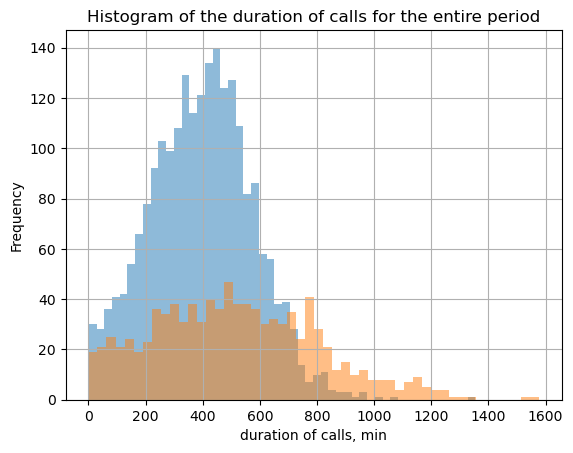

In [91]:
report.query('tariff == "smart"')['calls_total_duration'].hist(alpha = 0.5,bins = 50)
report.query('tariff == "ultra"')['calls_total_duration'].hist(alpha = 0.5,bins = 50)
plt.title('Histogram of the duration of calls for the entire period')
plt.xlabel('duration of calls, min')
plt.ylabel('Frequency')
plt.show()

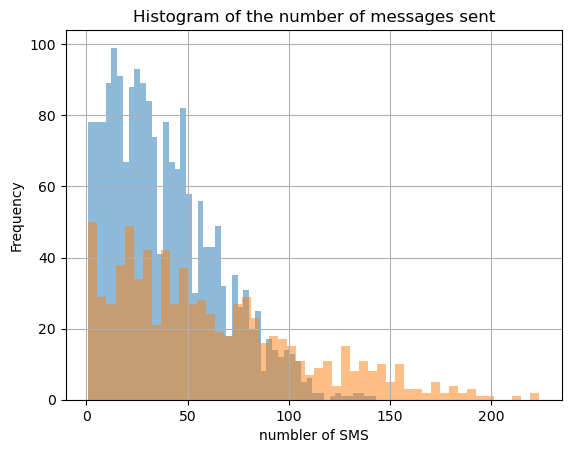

In [92]:
report.query('tariff == "smart"')['messages_sent'].hist(alpha = 0.5, bins = 50)
report.query('tariff == "ultra"')['messages_sent'].hist(alpha = 0.5, bins = 50)
plt.title('Histogram of the number of messages sent')
plt.xlabel('numbler of SMS')
plt.ylabel('Frequency')
plt.show()

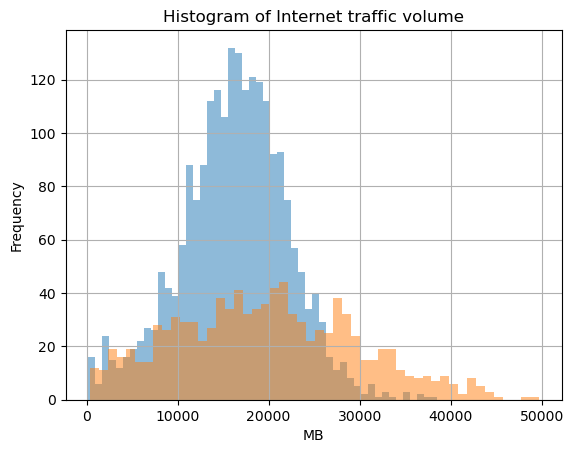

In [93]:
report.query('tariff == "smart"')['mb_used'].hist(alpha = 0.5, bins = 50)
report.query('tariff == "ultra"')['mb_used'].hist(alpha = 0.5, bins = 50)
plt.title('Histogram of Internet traffic volume')
plt.xlabel('MB')
plt.ylabel('Frequency')
plt.show()

The distributions of the duration of calls and the volume of Internet traffic are almost symmetrical (for analysis we can use the average value). The distribution of the number of SMS is asymmetric with a positive slope (we will use the median).

In [94]:
(report
 .pivot_table(index='tariff', 
              values=['calls_total_duration','messages_sent','mb_used'], 
              aggfunc=['mean','median','std','var']).round(2)
)

mean                                       median  \
       calls_total_duration   mb_used messages_sent calls_total_duration   
tariff                                                                     
smart                395.85  16222.94         38.72               398.85   
ultra                517.01  19688.68         61.16               498.95   

                                                std                         \
         mb_used messages_sent calls_total_duration  mb_used messages_sent   
tariff                                                                       
smart   16508.64          34.0               178.72  5852.97         26.79   
ultra   19409.03          51.0               288.50  9928.13         45.93   

                        var                             
       calls_total_duration      mb_used messages_sent  
tariff                                                  
smart              31940.46  34257208.73        717.59  
ultra              83232.30  98567864.33       2109.66

In [95]:
math.ceil(16223/1024)

16

In [96]:
math.ceil(19689/1024)

20

On average, for a month, users of the tariff "smart" requires 396 minutes of phone calls, 34 messages and 16 GB of Internet traffic, users of the tariff "ultra" requires 517 minutes of talk time, 51 messages and 20 GB of Internet traffic.


In [97]:
#tariffs = ['smart','ultra']
def grouped_bar_plot(val,title,agg,y):
    stat =  (report
        .groupby(['month','tariff'])[val]
        .agg([agg])
        .round(2)
    )
    stat.unstack(level=1).plot(kind='bar', subplots=False, title = title)

    plt.xlabel('month')
    plt.ylabel(y)

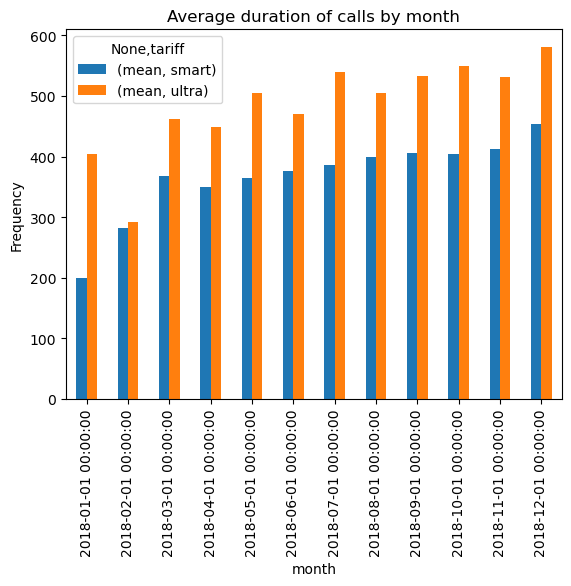

In [98]:
grouped_bar_plot('calls_total_duration', 'Average duration of calls by month', 'mean', 'Frequency')

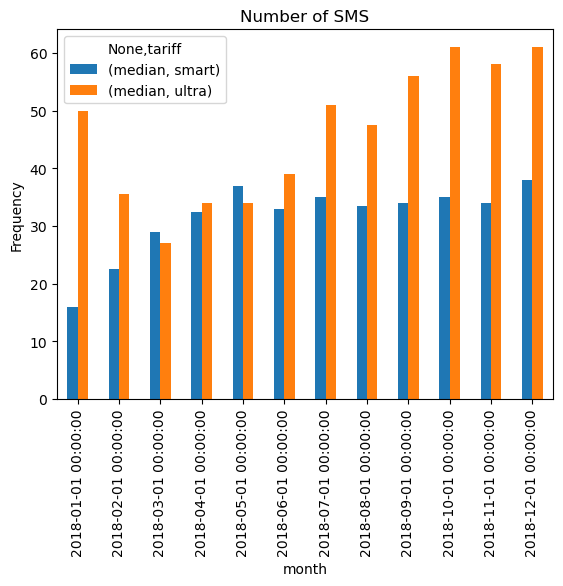

In [99]:
grouped_bar_plot('messages_sent', 'Number of SMS', 'median', 'Frequency')

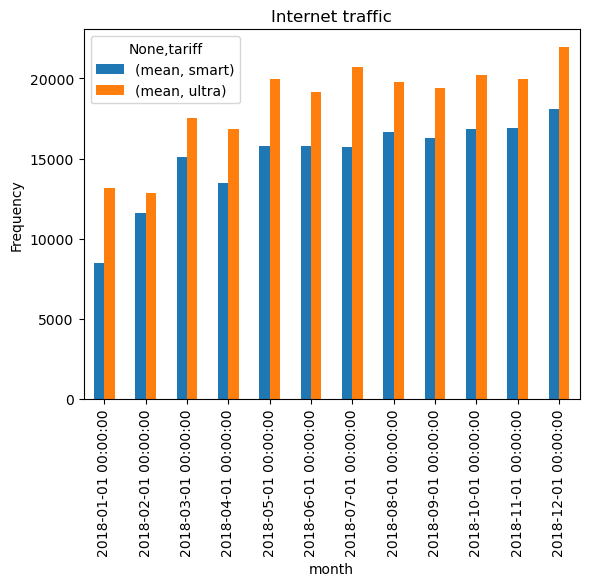

In [100]:
grouped_bar_plot('mb_used', 'Internet traffic', 'mean', 'Frequency')

User activity by tariff increases from January to December. On average, "ultra" tariff users talk on the phone, text (except for March and May) and use the Internet more every month than "smart" tariff users. 

In [101]:
(report
 .pivot_table(index='tariff', 
              values=['profit'], 
              aggfunc=['mean','median','std','var','sum']).round(2)
)

,mean,median,std,var,sum
,profit,profit,profit,profit,profit
tariff,,,,,
smart,1250.05,951.0,799.94,639908.59,2816365.0
ultra,2067.64,1950.0,372.63,138855.04,2080050.0


## Hypothesis testing

Let's test the hypothesis of whether Smart and Ultra tariff users have different revenues.
Since there is no additional information about what the revenue was before the tariffs were applied, we will test the hypothesis that the average revenue by tariff is equal.

To evaluate the hypothesis, let's select the variable 'profit' and select the rows with tariff data from the table.

Let's make the null hypothesis that the mean values of the distributions are equal.
An alternative hypothesis is that the mean values of the distributions are not equal.

In [102]:
sample_1 = report.query('tariff == "smart"')['profit']
sample_2 = report.query('tariff == "ultra"')['profit']

alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Rejecting the null hypothesis")
else:
    print("It was not possible to reject the null hypothesis") 

p-value: 1.31100688757859e-184
Rejecting the null hypothesis


The resulting p-value suggests that, with a probability of 0%, this or a larger difference in users' revenues by fare can be obtained by chance. This is clearly too small a probability to conclude that the average revenues are equal.

Let us test the hypothesis that the average revenue of users in Moscow and other regions is different.

Let us formulate the null hypothesis as follows: the average revenue of users is equal.
An alternative hypothesis: the average revenue of users in Moscow and other regions is not equal.

In [103]:
[report.query('city == "Москва"')['profit'].mean(),
report.query('city != "Москва"')['profit'].mean()]

[1527.1003236245954, 1496.6554335478986]

In [104]:
sample_1 = report.query('city == "Москва"')['profit']
sample_2 = report.query('city != "Москва"')['profit']

alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Rejecting the null hypothesis")
else:
    print("It was not possible to reject the null hypothesis") 

p-значение: 0.38995130725910643
It was not possible to reject the null hypothesis


The resulting p-value suggests that although the average revenue of users in different regions is unequal, with a probability of almost 40% such or greater difference can be obtained by chance. This is clearly too high a probability to conclude that there is a significant difference between the average revenue of Moscow and regional users.

## Conclusion.

We analyzed data on the activity of "Megaline" operator users on a sample of 500 network users during the period from January to December 2018. 
- Created a summary table with information about the amount of minutes of telephone calls, messages sent and the volume of Internet traffic of users by month.
- Calculated the amount of revenue for users depending on tariffs. The average value according to the available sampling was 1250 and 2068 rubles per month for users of Smart and Ultra tariffs, respectively.
- The average monthly requirement for smart tariff users is 396 minutes for calls, 34 messages and 16GB of Internet traffic, while ultra tariff users need 517 minutes for calls, 51 messages and 20GB of Internet traffic.
- The hypothesis that the average user revenue per tariff is equal has been put forward and refuted.
- The hypothesis that the revenue of users in Moscow and other regions does not differ has been proposed and not refuted.